In [ ]:
#| hide
!pip install -Uqq nixtla hierarchicalforecast

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Temporal Hierarchical Forecasting with TimeGPT

In this notebook, we demonstrate how to use TimeGPT for temporal hierarchical forecasting. We will use a dataset that has an hourly frequency, and we create forecasts with TimeGPT for both the hourly and the 2-hourly frequency level. The latter constitutes the timeseries when it is aggregated across 2-hour windows. Subsequently, we can use temporal reconciliation techniques to improve the forecasting performance of TimeGPT.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/23_temporalhierarchical')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/23_temporalhierarchical.ipynb)

## 1. Load and Process Data

In [ ]:
import numpy as np
import pandas as pd

from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series
from utilsforecast.losses import mae, rmse
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # api_key = 'my_api_key_provided_by_nixtla'
)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df['ds'] = pd.to_datetime(df['ds'])
df_sub = df.query('unique_id == "DE"')

In [ ]:
df_train = df_sub.query('ds < "2017-12-29"')
df_test = df_sub.query('ds >= "2017-12-29"')
df_train.shape, df_test.shape

((1632, 12), (48, 12))

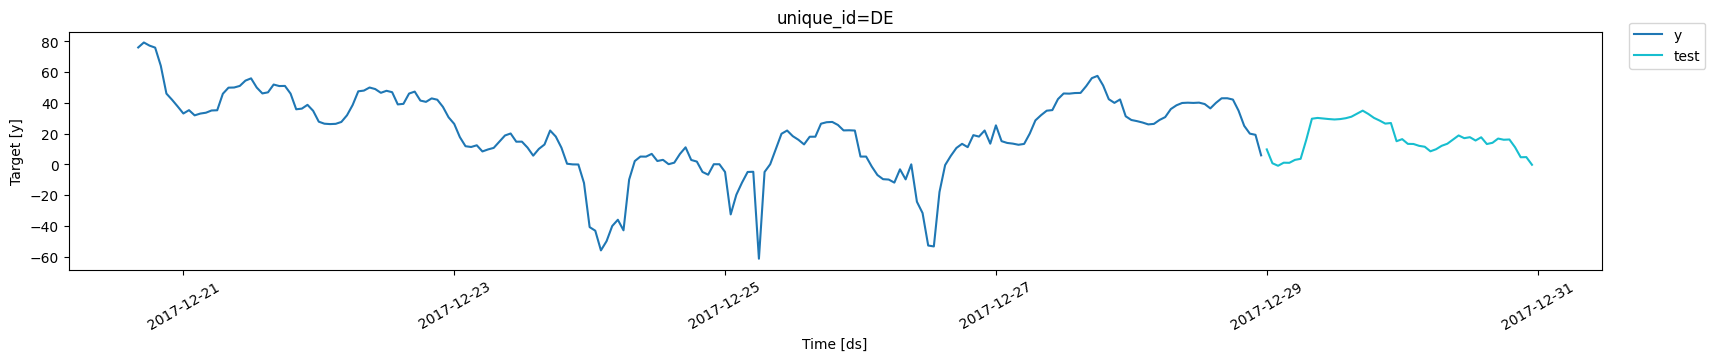

In [ ]:
plot_series(df_train[['unique_id','ds','y']][-200:], forecasts_df= df_test[['unique_id','ds','y']].rename(columns={'y': 'test'}))

## 2. Temporal aggregation

We are interested in generating forecasts for the hourly and 2-hourly windows. To do so, we make use of hierarchical forecasting techniques. 

We first define the temporal aggregation spec. The spec is a dictionary in which the keys are the name of the aggregation and the value is the amount of bottom-level timesteps that should be aggregated in that aggregation. 

In this example, we choose a temporal aggregation of a 2-hour period and a 1-hour period (the bottom level).

In [ ]:
spec_temporal = { "2-hour-period": 2, "1-hour-period": 1}

We next compute the temporally aggregated train- and test sets using the `aggregate_temporal` function from `hierarchicalforecast`. Note that we have different aggregation matrices `S` for the train- and test set, as the test set contains temporal hierarchies that are not included in the train set.

In [ ]:
from hierarchicalforecast.utils import aggregate_temporal

In [ ]:
Y_train, S_train, tags_train = aggregate_temporal(df=df_train[['unique_id','ds','y']], spec=spec_temporal)
Y_test, S_test, tags_test = aggregate_temporal(df=df_test[['unique_id','ds','y']],  spec=spec_temporal)

The aggregation matrix `S_test` aggregates the lowest temporal granularity (hour) up to 2-hour periods. For example, the first 2-hour period, named `2-hour-period-1`, can be constructed by summing the first two hour-periods, `1-hour-period-1` and `1-hour-period-2`.

In [ ]:
S_test.iloc[:5, :5]

,temporal_id,1-hour-period-1,1-hour-period-2,1-hour-period-3,1-hour-period-4
0,2-hour-period-1,1.0,1.0,0.0,0.0
1,2-hour-period-2,0.0,0.0,1.0,1.0
2,2-hour-period-3,0.0,0.0,0.0,0.0
3,2-hour-period-4,0.0,0.0,0.0,0.0
4,2-hour-period-5,0.0,0.0,0.0,0.0


### 3b. Computing base forecasts

Now, we need to compute base forecasts for each temporal aggregation. The following cell computes the **base forecasts** for each temporal aggregation in `Y_train` using TimeGPT. 

Note that both frequency and horizon are different for each temporal aggregation. In this example, the lowest level has a hourly frequency, and a horizon of `48`. The `2-hourly-period` aggregation thus has a 2-hourly frequency with a horizon of `24`.

In [ ]:
Y_hats = []
id_cols = ["unique_id", "temporal_id", "ds", "y"]
# We will train a model for each temporal level
for level, temporal_ids_train in tags_train.items():
    # Filter the data for the level
    Y_level_train = Y_train.query("temporal_id in @temporal_ids_train")
    temporal_ids_test = tags_test[level]
    Y_level_test = Y_test.query("temporal_id in @temporal_ids_test")
    # For each temporal level we have a different frequency and forecast horizon
    freq_level = pd.infer_freq(Y_level_train["ds"].unique())
    horizon_level = Y_level_test["ds"].nunique()
    # Train a model and create forecasts
    Y_hat_level = nixtla_client.forecast(df=Y_level_train[["ds", "unique_id", "y"]], h=horizon_level)
    # Add the test set to the forecast
    Y_hat_level = Y_hat_level.merge(Y_level_test, on=["ds", "unique_id"], how="left")
    # Put cols in the right order (for readability)
    Y_hat_cols = id_cols + [col for col in Y_hat_level.columns if col not in id_cols]
    Y_hat_level = Y_hat_level[Y_hat_cols]
    # Append the forecast to the list
    Y_hats.append(Y_hat_level)

Y_hat = pd.concat(Y_hats, ignore_index=True)

Observe that `Y_hat` contains all the forecasts but they are not coherent with each other. For example, consider the forecasts for the first time period of both frequencies.

In [ ]:
Y_hat.query("temporal_id in ['2-hour-period-1', '1-hour-period-1', '1-hour-period-2']")

,unique_id,temporal_id,ds,y,TimeGPT
0,DE,2-hour-period-1,2017-12-29 01:00:00,10.45,16.949448
24,DE,1-hour-period-1,2017-12-29 00:00:00,9.73,-0.241489
25,DE,1-hour-period-2,2017-12-29 01:00:00,0.72,-3.456482


The ground truth value `y` for the first 2-hour period is 10.45, and the sum of the ground truth values for the first two 1-hour periods is (9.73 + 0.72) = 10.45. Hence, these values are coherent with each other.

However, the forecast for the first 2-hour period is 16.95, but the sum of the forecasts for the first two 1-hour periods is -3.69. Hence, these forecasts are clearly not coherent with each other. 

We will use reconciliation techniques to make these forecasts better coherent with each other.

### 3c. Reconcile forecasts

We can use the `HierarchicalReconciliation` class to reconcile the forecasts. In this example we use `MinTrace`. Note that we have to set `temporal=True` in the `reconcile` function.

In [ ]:
from hierarchicalforecast.methods import MinTrace
from hierarchicalforecast.core import HierarchicalReconciliation

In [ ]:
reconcilers = [
    MinTrace(method="wls_struct"),
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec = hrec.reconcile(Y_hat_df=Y_hat, S=S_test, tags=tags_test, temporal=True)

## 4. Evaluation 

The `HierarchicalForecast` package includes the `evaluate` function to evaluate the different hierarchies.

We evaluate the temporally aggregated forecasts _across all temporal aggregations_.

In [ ]:
import hierarchicalforecast.evaluation as hfe
from utilsforecast.losses import mae

In [ ]:
evaluation = hfe.evaluate(df = Y_rec.drop(columns = 'unique_id'),
                      tags = tags_test,
                      metrics = [mae],
                      id_col='temporal_id')

numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.3}'.format).astype(np.float64)

In [ ]:
evaluation

,level,metric,TimeGPT,TimeGPT/MinTrace_method-wls_struct
0,2-hour-period,mae,25.2,12.00
1,1-hour-period,mae,18.5,6.16
2,Overall,mae,20.8,8.12


As we can see, we improved performance of TimeGPT's predictions both for the 2-hour period and for the 1-hour period. 

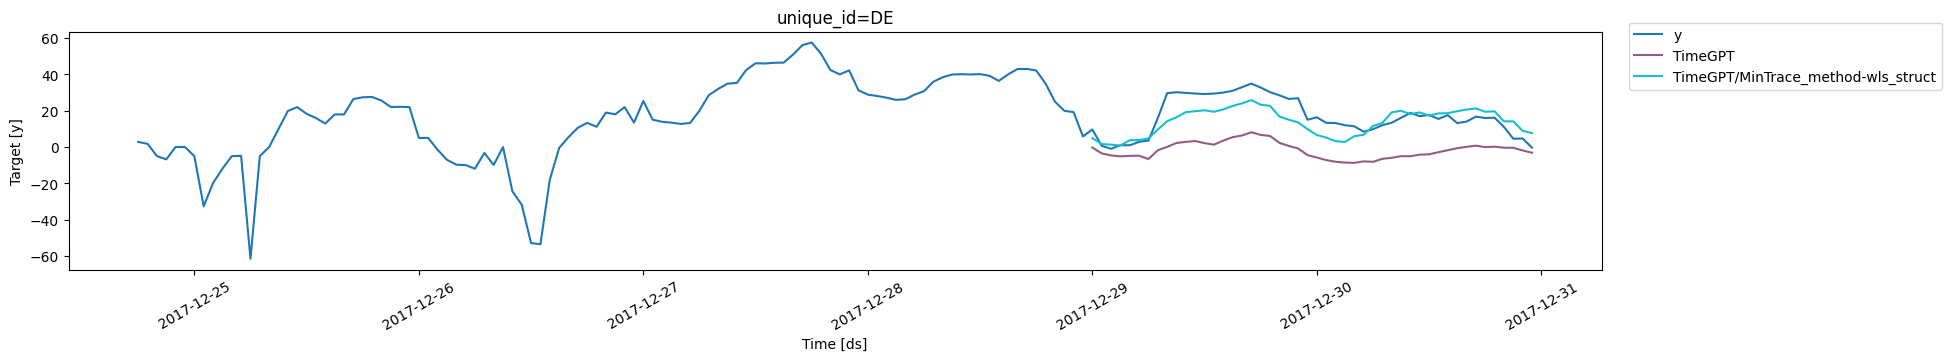

In [ ]:
plot_series(df_sub.iloc[-150:], forecasts_df= Y_rec.query("temporal_id in @tags_test['1-hour-period']").drop(columns=["y", "temporal_id"]))

Also, we can now verify that the forecasts are better coherent with each other. For the first 2-hour period, our forecast after reconciliation is 6.63, and the sum of the forecasts for the first two 1-hour periods is 1.7 + 4.92 = 6.63. Hence, we now have accurate and coherent forecasts across frequencies.

In [ ]:
Y_rec.query("temporal_id in ['2-hour-period-1', '1-hour-period-1', '1-hour-period-2']")

,unique_id,temporal_id,ds,y,TimeGPT,TimeGPT/MinTrace_method-wls_struct
0,DE,2-hour-period-1,2017-12-29 01:00:00,10.45,16.949448,6.625738
24,DE,1-hour-period-1,2017-12-29 00:00:00,9.73,-0.241489,4.920365
25,DE,1-hour-period-2,2017-12-29 01:00:00,0.72,-3.456482,1.705373
